In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# List of years for the datasets
years = [2019, 2020, 2021, 2022, 2023]

# Load and concatenate the datasets
df_list = [pd.read_csv(f'finalData/NBA{year}.csv') for year in years]
nba_data = pd.concat(df_list, ignore_index=True)

nba_data['GameID'] = nba_data.apply(lambda row: f"{row['Date']}_{sorted([row['Team'], row['Opponent']])[0]}_{sorted([row['Team'], row['Opponent']])[1]}", axis=1)

# Display the first few rows to verify it's loaded correctly
print(nba_data.head())


/var/folders/7p/lxd_ccrx4_s2kfc0f3nyhnw80000gn/T/ipykernel_59960/3904115729.py:8: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(f'finalData/NBA{year}.csv') for year in years]
/var/folders/7p/lxd_ccrx4_s2kfc0f3nyhnw80000gn/T/ipykernel_59960/3904115729.py:8: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(f'finalData/NBA{year}.csv') for year in years]


  Team Opponent Location        Date WL_team  MIN_team  PTS_team  \
0  GSW      OKC        H  2018-10-16       W       240       108   
1  OKC      GSW        V  2018-10-16       L       240       100   
2  BOS      PHI        H  2018-10-16       W       240       105   
3  PHI      BOS        V  2018-10-16       L       240        87   
4  MEM      IND        V  2018-10-17       L       240        83   

   PTS_team_rolling_avg  FGM_team  FGA_team  ...  PlusMinus_opponent  \
0                 108.0        42        95  ...                -8.0   
1                 100.0        33        91  ...                 8.0   
2                 105.0        42        97  ...               -18.0   
3                  87.0        34        87  ...                18.0   
4                  83.0        25        84  ...                28.0   

   ORtg_opponent  ORtg_opponent_rolling_avg  DRtg_opponent  \
0      94.091080                  94.091080     101.618367   
1     101.010101                 1

/var/folders/7p/lxd_ccrx4_s2kfc0f3nyhnw80000gn/T/ipykernel_59960/3904115729.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nba_data['GameID'] = nba_data.apply(lambda row: f"{row['Date']}_{sorted([row['Team'], row['Opponent']])[0]}_{sorted([row['Team'], row['Opponent']])[1]}", axis=1)


In [2]:
# Finding the underdog and over/under value
over_under_values = {}
for game_id in nba_data['GameID'].unique():
    game_df = nba_data[nba_data['GameID'] == game_id]
    if game_df.shape[0] == 2:  # Ensure there are exactly two teams (two entries per game)
        underdog_entry = game_df.loc[game_df['ML'].idxmax()]  # The underdog has the maximum ML value if positive or least negative
        over_under_values[game_id] = underdog_entry['Close']

# Applying the over/under value from the underdog to both teams
nba_data['Adjusted_Close'] = nba_data['GameID'].map(over_under_values)

print(nba_data)

      Team Opponent Location        Date WL_team  MIN_team  PTS_team  \
0      GSW      OKC        H  2018-10-16       W       240       108   
1      OKC      GSW        V  2018-10-16       L       240       100   
2      BOS      PHI        H  2018-10-16       W       240       105   
3      PHI      BOS        V  2018-10-16       L       240        87   
4      MEM      IND        V  2018-10-17       L       240        83   
...    ...      ...      ...         ...     ...       ...       ...   
10341  HOU      LAL        V  2023-01-16       L       240       132   
10342  ATL      MIA        H  2023-01-16       W       240       121   
10343  WAS      GSW        H  2023-01-16       L       240       118   
10344  BOS      CHA        V  2023-01-16       W       240       130   
10345  CHA      BOS        H  2023-01-16       L       240       118   

       PTS_team_rolling_avg  FGM_team  FGA_team  ...  ORtg_opponent  \
0                108.000000        42        95  ...      94.091

/var/folders/7p/lxd_ccrx4_s2kfc0f3nyhnw80000gn/T/ipykernel_59960/973368142.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nba_data['Adjusted_Close'] = nba_data['GameID'].map(over_under_values)


In [3]:
# Convert 'Close' to float, coercing errors to NaN
nba_data['Adjusted_Close'] = pd.to_numeric(nba_data['Adjusted_Close'], errors='coerce')

# Check the data type again to confirm the conversion
print(nba_data['Adjusted_Close'].dtype)

# Optionally, check for any NaN values that resulted from the conversion
print(nba_data['Adjusted_Close'].isnull().sum())

# If there are NaN values and you decide to drop them
nba_data.dropna(subset=['Adjusted_Close'], inplace=True)

nba_data['Total_Score'] = nba_data['Final'] + nba_data['PTS_opponent']

# Continue with your calculations or further data preparation
# For example, recreating the 'over_under' column:
nba_data['over_under'] = (nba_data['Total_Score'] > nba_data['Adjusted_Close']).astype(int)

# Verify the changes
print(nba_data[['Total_Score', 'Adjusted_Close', 'over_under']].head())

#print the number of 0s and 1s in the over_under column
print(nba_data['over_under'].value_counts())

float64
1416
   Total_Score  Adjusted_Close  over_under
0        208.0           220.5           0
1        208.0           220.5           0
2        192.0           211.5           0
3        192.0           211.5           0
4        194.0           204.5           0
over_under
1    4503
0    4427
Name: count, dtype: int64


/var/folders/7p/lxd_ccrx4_s2kfc0f3nyhnw80000gn/T/ipykernel_59960/1352405380.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nba_data['Total_Score'] = nba_data['Final'] + nba_data['PTS_opponent']
/var/folders/7p/lxd_ccrx4_s2kfc0f3nyhnw80000gn/T/ipykernel_59960/1352405380.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nba_data['over_under'] = (nba_data['Total_Score'] > nba_data['Adjusted_Close']).astype(int)


         Date WL_team  MIN_team  PTS_team  PTS_team_rolling_avg  FGM_team  \
0  2018-10-16       W       240 -0.282303             -0.434166        42   
1  2018-10-16       L       240 -0.921230             -1.418852        33   
2  2018-10-16       W       240 -0.521901             -0.803423        42   
3  2018-10-16       L       240 -1.959487             -3.018968        34   
4  2018-10-17       L       240 -2.278951             -3.511311        25   

   FGA_team  FGP_team  FGP_team_rolling_avg  ThreePM_team  ...  Opponent_ORL  \
0        95 -0.399651             -0.632997             7  ...         False   
1        91 -1.853703             -2.968847            10  ...         False   
2        97 -0.565303             -0.899106            11  ...         False   
3        87 -1.338343             -2.140951             5  ...         False   
4        84 -3.050075             -4.890749            10  ...         False   

   Opponent_PHI  Opponent_POR  Opponent_SAC  Opponent_SA

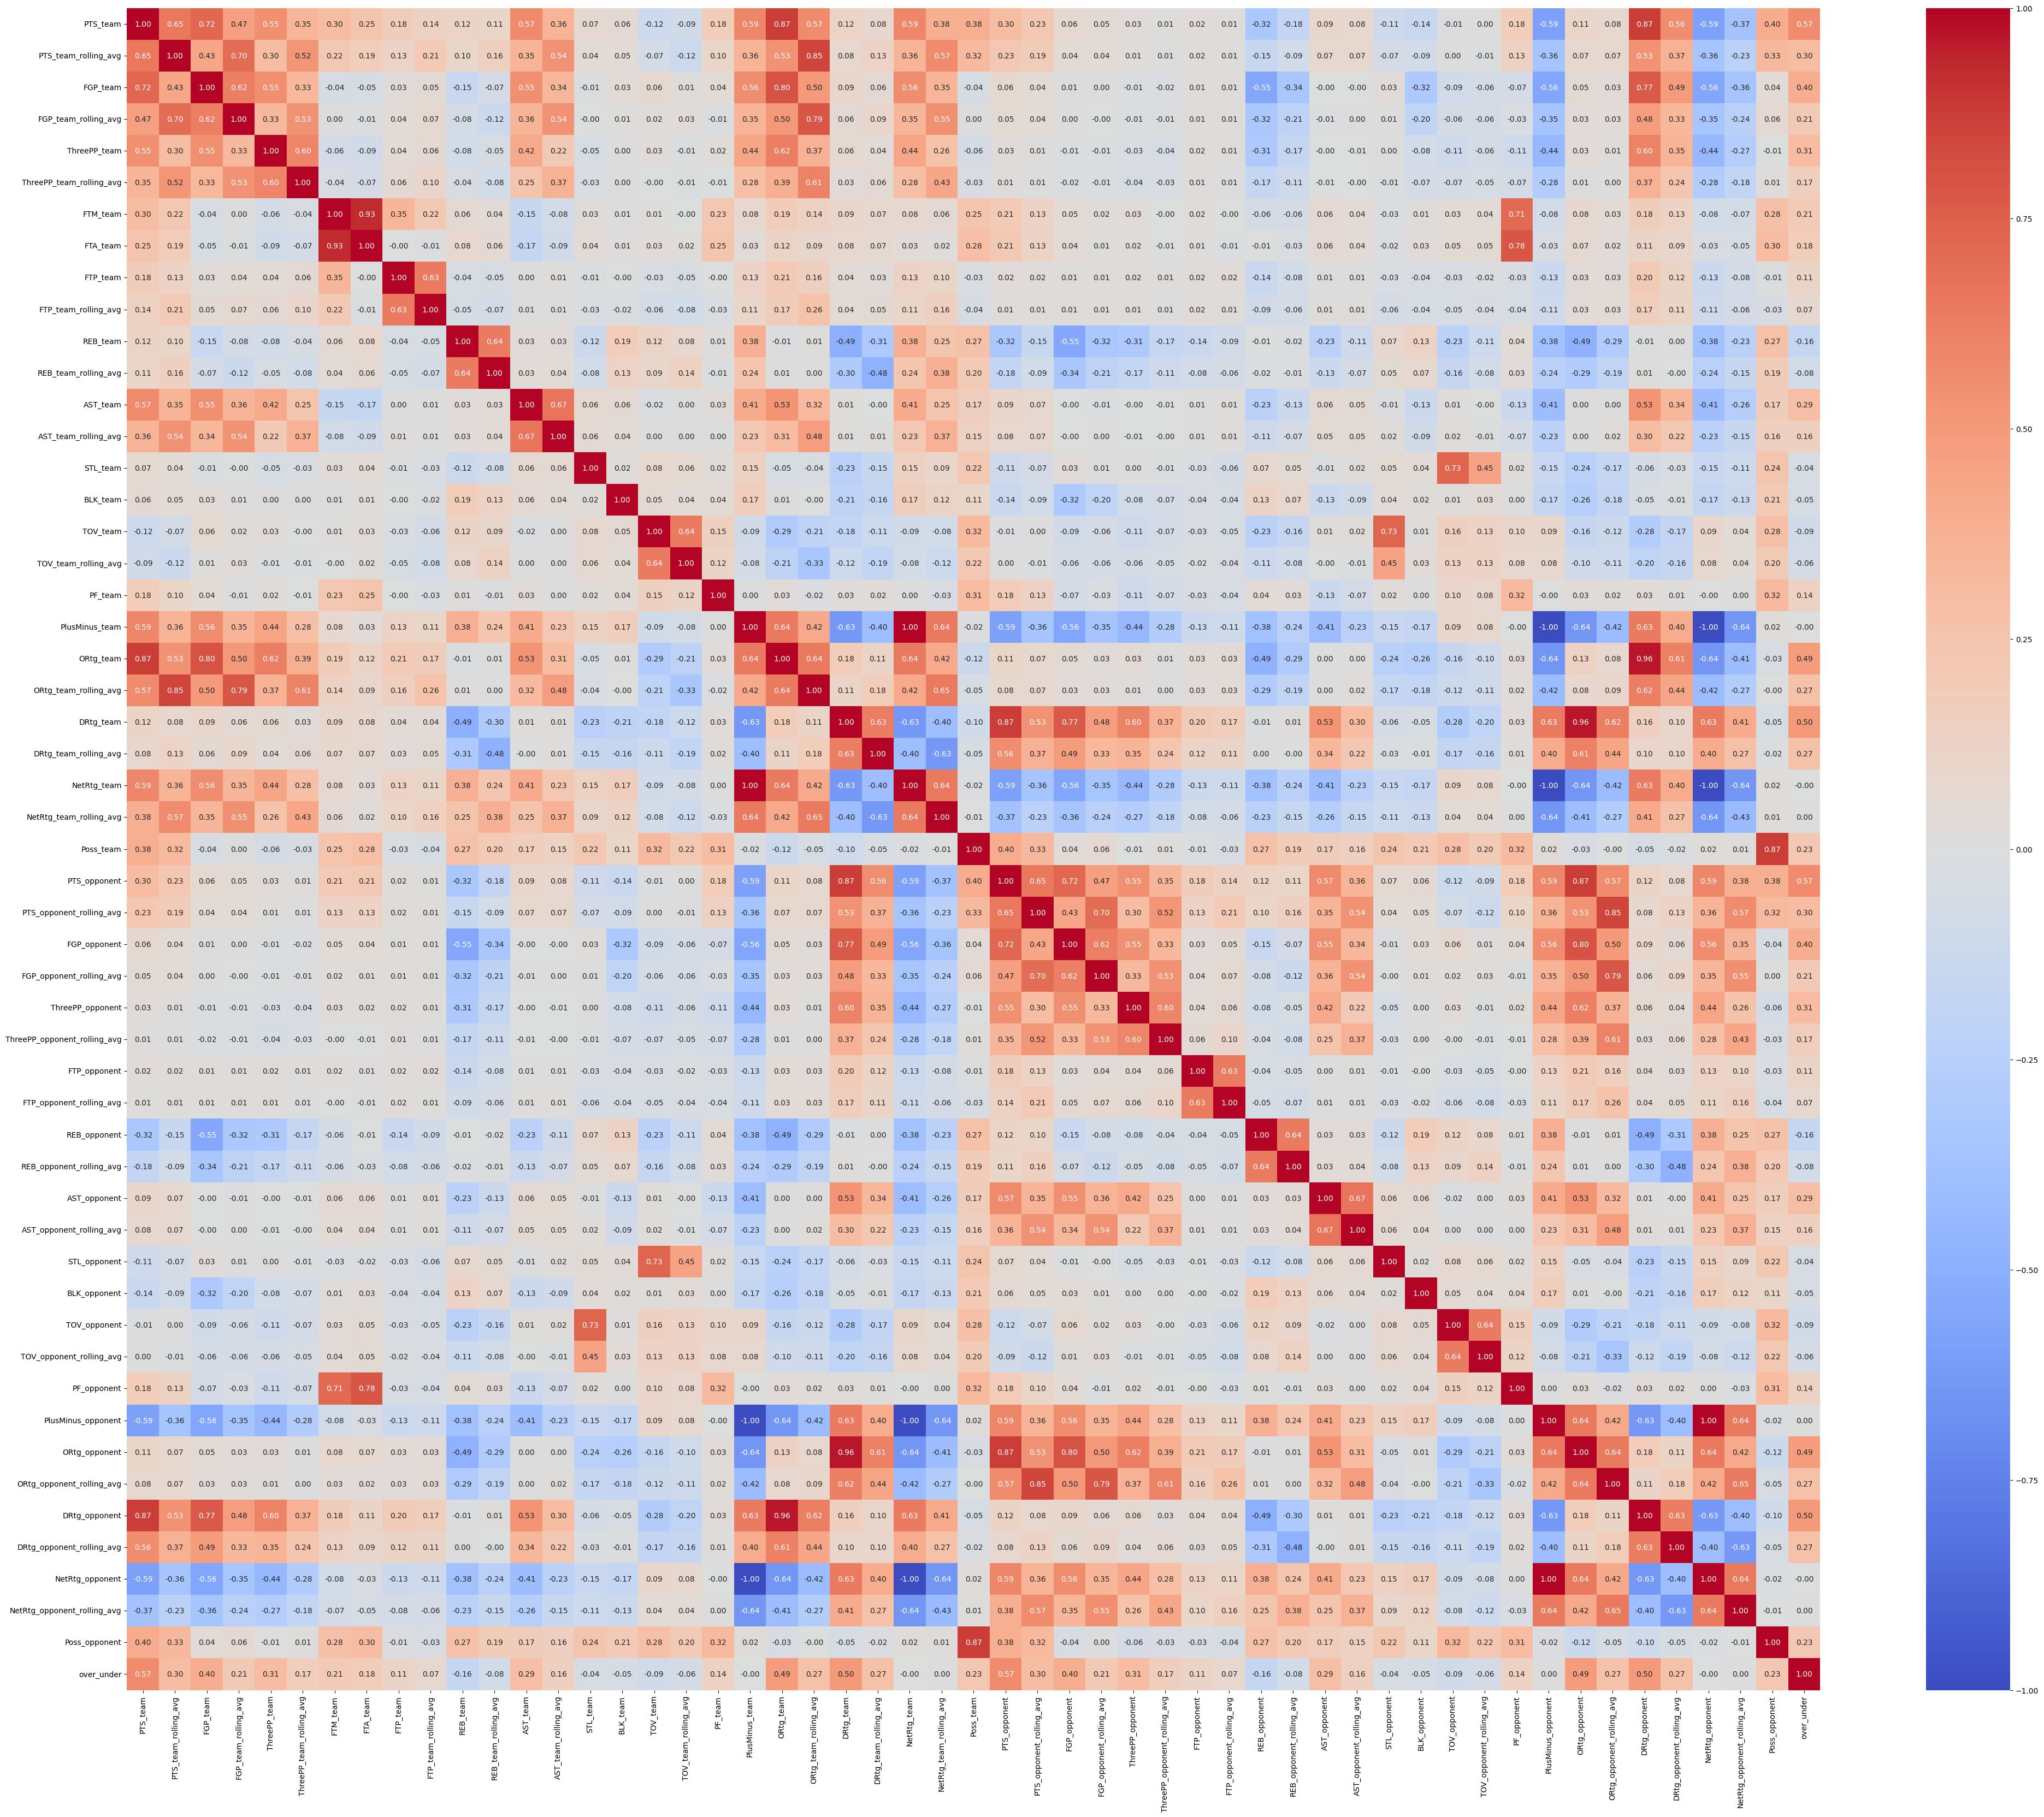

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

#one hot encoding
df = pd.get_dummies(nba_data, columns=['Team', 'Opponent', 'Location'])

# Assuming you've determined a list of potential features including new engineered features
team_opponent_features = [
    "PTS_team", "PTS_team_rolling_avg", "FGP_team", "FGP_team_rolling_avg", "ThreePP_team", "ThreePP_team_rolling_avg",
    "FTM_team", "FTA_team", "FTP_team", "FTP_team_rolling_avg", "REB_team", "REB_team_rolling_avg",
    "AST_team", "AST_team_rolling_avg", "STL_team", "BLK_team", "TOV_team", "TOV_team_rolling_avg", "PF_team", "PlusMinus_team",
    "ORtg_team", "ORtg_team_rolling_avg", "DRtg_team", "DRtg_team_rolling_avg", "NetRtg_team", "NetRtg_team_rolling_avg", "Poss_team",
    "PTS_opponent", "PTS_opponent_rolling_avg", "FGP_opponent", "FGP_opponent_rolling_avg", "ThreePP_opponent", "ThreePP_opponent_rolling_avg",
    "FTP_opponent", "FTP_opponent_rolling_avg", "REB_opponent", "REB_opponent_rolling_avg", "AST_opponent", "AST_opponent_rolling_avg",
    "STL_opponent", "BLK_opponent", "TOV_opponent", "TOV_opponent_rolling_avg", "PF_opponent", "PlusMinus_opponent", "ORtg_opponent",
    "ORtg_opponent_rolling_avg", "DRtg_opponent", "DRtg_opponent_rolling_avg", "NetRtg_opponent", "NetRtg_opponent_rolling_avg", "Poss_opponent",
]

# Include the target
# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the numeric features
df[team_opponent_features] = scaler.fit_transform(df[team_opponent_features])
# # Ensure 'Team' and 'Opponent' columns are present in the DataFrame
# df = df.reindex(columns=team_opponent_features + ['over_under'])

# Display the first few rows to verify the transformation
print(df.head())

# Compute the correlation matrix
correlation_matrix = df[team_opponent_features + ['over_under']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(50, 40))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
features_with_target = team_opponent_features + ['over_under']

In [5]:
#print out all the correlation matrix values
print(correlation_matrix['over_under'])

#save the correlation matrix to a csv file
correlation_matrix['over_under'].to_csv('team_correlation_matrix.csv')

high_corr_team_features = correlation_matrix.index[abs(correlation_matrix['over_under']) > 0.2].tolist()

# Print the highly correlated features
print(high_corr_team_features)

PTS_team                        0.569889
PTS_team_rolling_avg            0.302259
FGP_team                        0.396858
FGP_team_rolling_avg            0.214028
ThreePP_team                    0.309461
ThreePP_team_rolling_avg        0.171392
FTM_team                        0.209608
FTA_team                        0.180531
FTP_team                        0.112920
FTP_team_rolling_avg            0.071439
REB_team                       -0.164239
REB_team_rolling_avg           -0.080909
AST_team                        0.290145
AST_team_rolling_avg            0.156690
STL_team                       -0.041225
BLK_team                       -0.053484
TOV_team                       -0.089561
TOV_team_rolling_avg           -0.063373
PF_team                         0.140737
PlusMinus_team                 -0.000121
ORtg_team                       0.490541
ORtg_team_rolling_avg           0.268602
DRtg_team                       0.496331
DRtg_team_rolling_avg           0.271027
NetRtg_team     

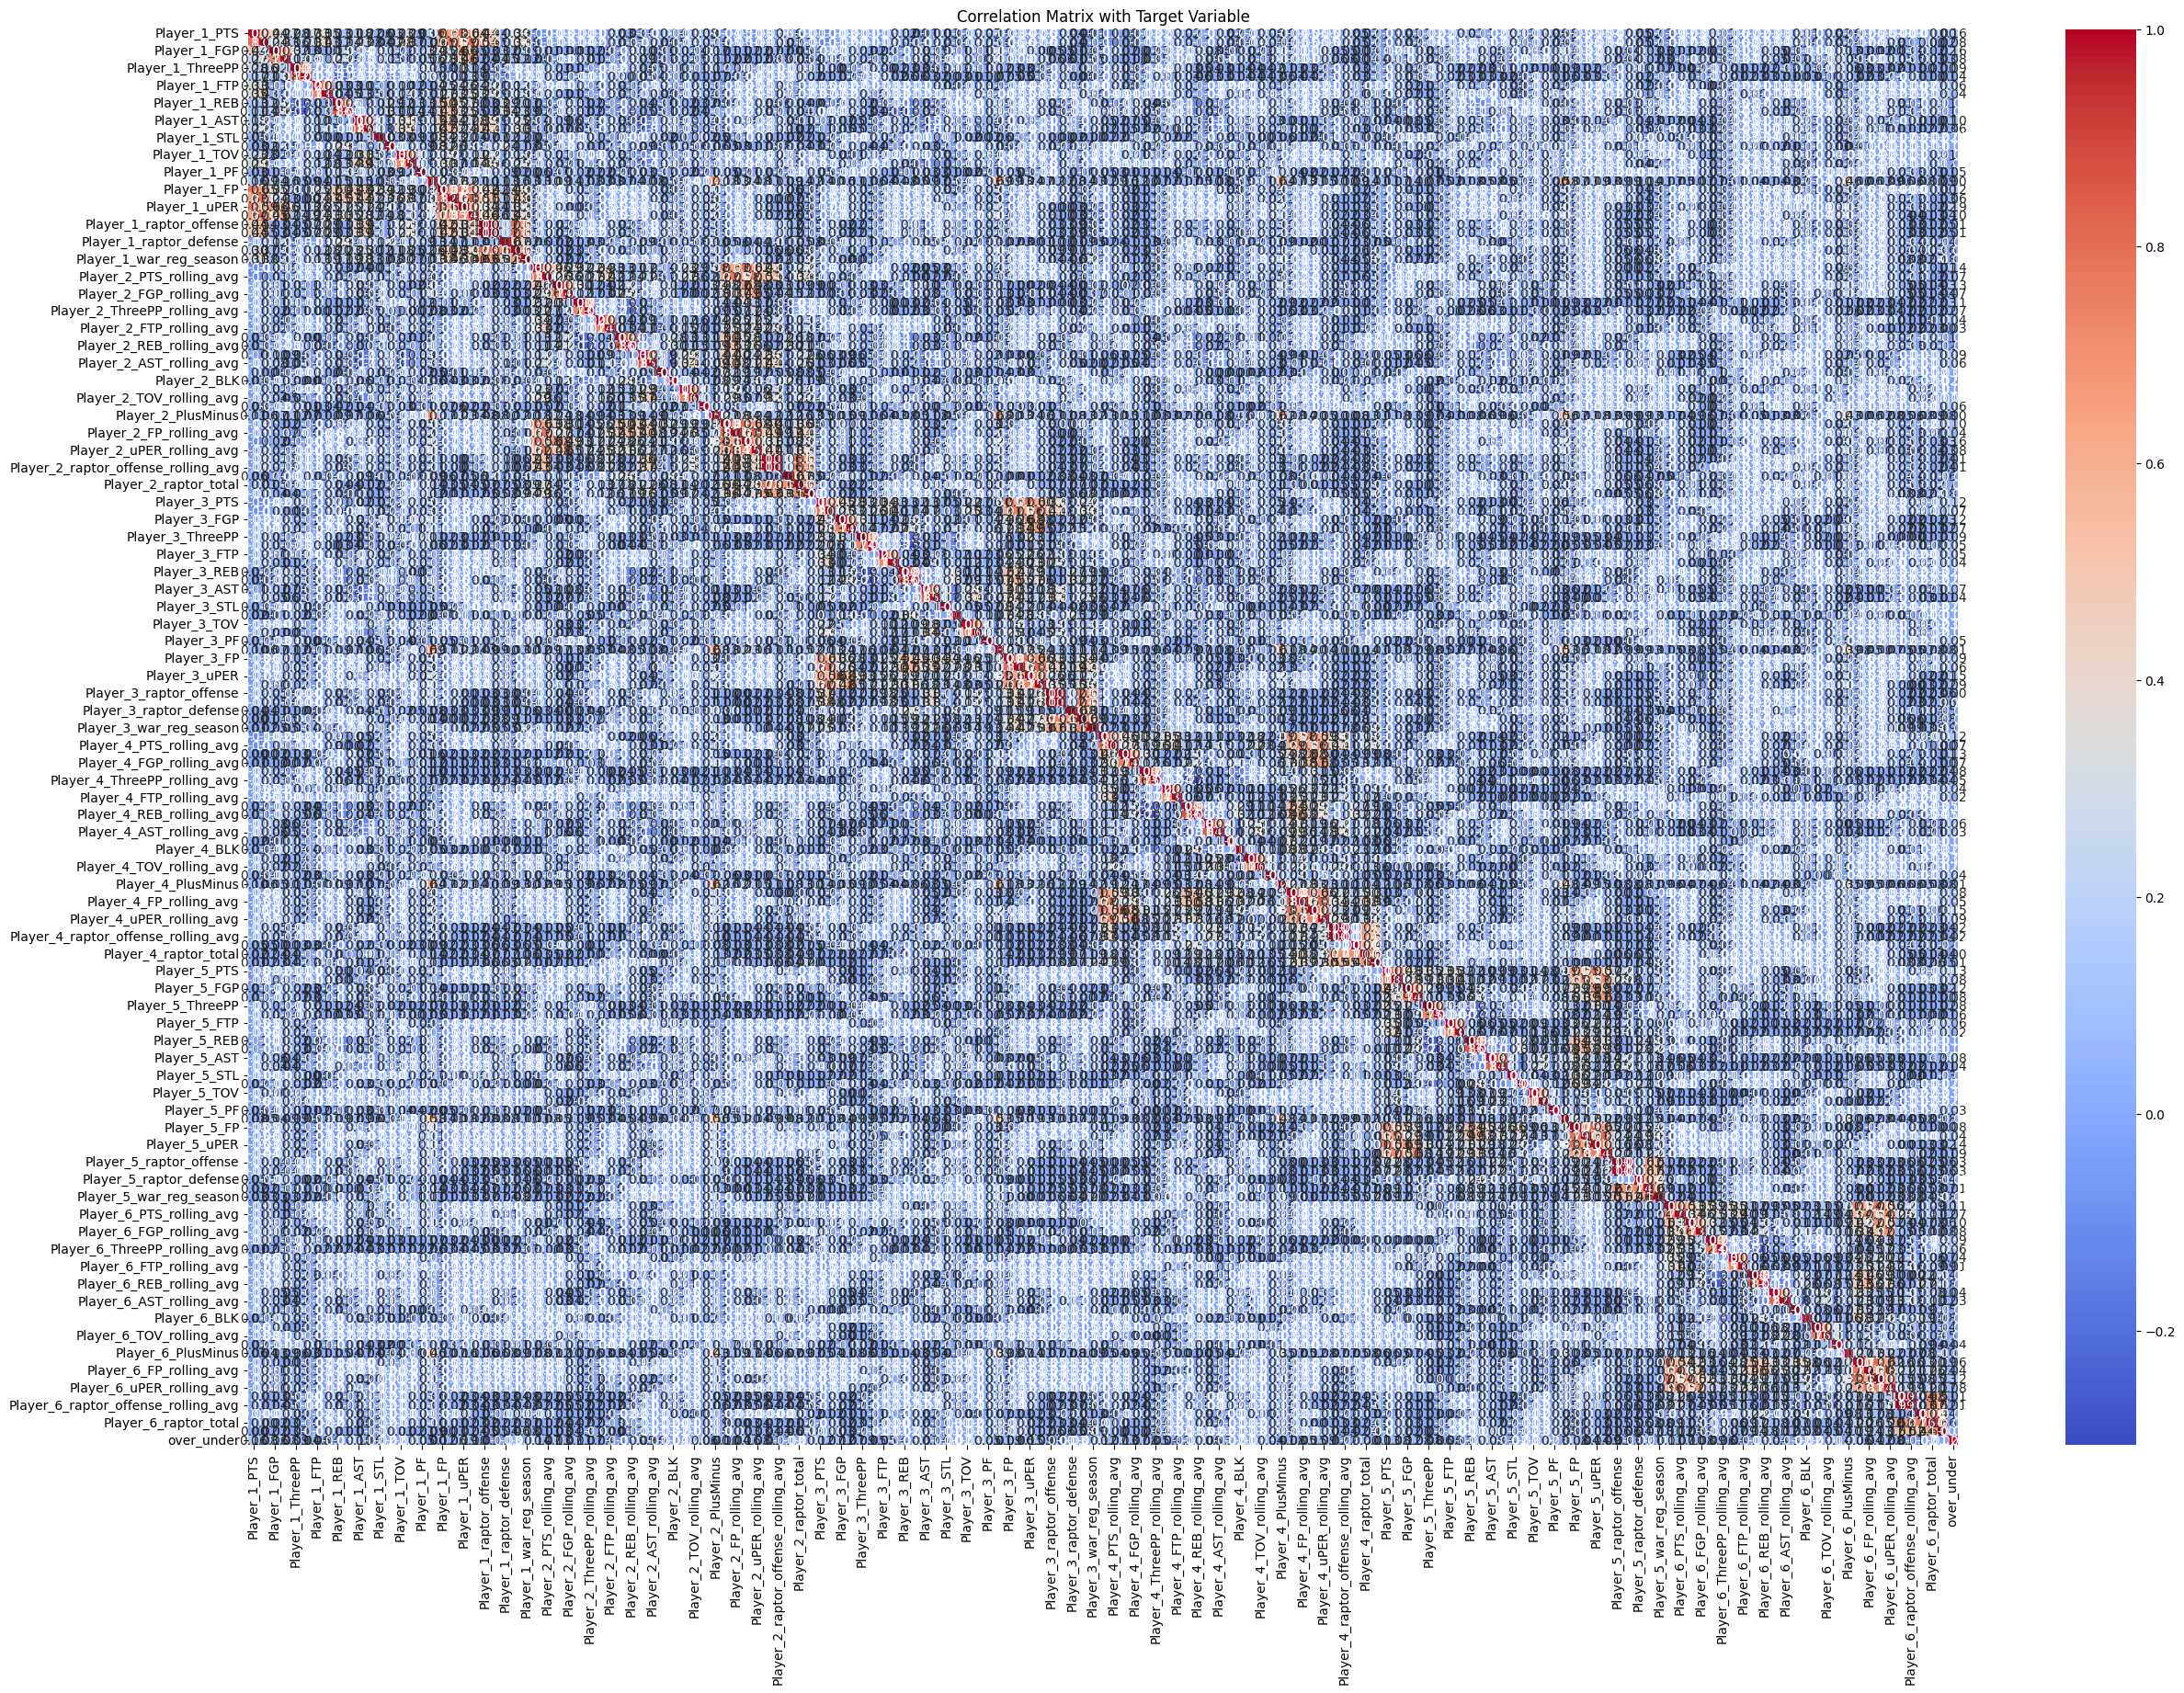

In [6]:
# Base player features for one player
base_player_features = [
    "PTS", "PTS_rolling_avg", "FGP", "FGP_rolling_avg",
    "ThreePP", "ThreePP_rolling_avg", "FTP", "FTP_rolling_avg",
    "REB", "REB_rolling_avg", "AST", "AST_rolling_avg",
    "STL", "BLK", "TOV", "TOV_rolling_avg",
    "PF", "PlusMinus", "FP", "FP_rolling_avg",
    "uPER", "uPER_rolling_avg", "raptor_offense", "raptor_offense_rolling_avg",
    "raptor_defense", "raptor_total", "war_reg_season"
]

# Generate features for all players
all_player_features = []
for i in range(1, 7):  # For players 1 to 6
    player_features = [f"Player_{i}_{feature}" for feature in base_player_features]
    all_player_features.extend(player_features)

# df_encoded = pd.get_dummies(df, columns=['Team', 'Opponent', 'Location'])  # Assuming 'Team' and 'Opponent' are categorical
# df_encoded = df_encoded[columns_to_keep]  # Fix: Use df_encoded instead of df

#scale the player features
df[all_player_features] = scaler.fit_transform(df[all_player_features])


features_with_target = all_player_features + ['over_under']
# Now compute the correlation matrix with these new numeric columns
correlation_matrix = df[features_with_target].corr()

# Plotting the correlation matrix
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with Target Variable')
plt.show()

In [7]:
#print out all the correlation matrix values
print(correlation_matrix['over_under'])

#save the correlation matrix to a csv file
correlation_matrix['over_under'].to_csv('player_correlation_matrix.csv')

#get all the columns above/below +0.1/-0.1 correlation
high_corr_player_features = correlation_matrix.index[abs(correlation_matrix['over_under']) > 0.1].tolist()

# Print the highly correlated features
print(high_corr_player_features)

Player_1_PTS                           0.158578
Player_1_PTS_rolling_avg               0.076193
Player_1_FGP                           0.156496
Player_1_FGP_rolling_avg               0.077772
Player_1_ThreePP                       0.088933
                                         ...   
Player_6_raptor_offense_rolling_avg    0.011532
Player_6_raptor_defense               -0.021781
Player_6_raptor_total                 -0.009980
Player_6_war_reg_season               -0.015609
over_under                             1.000000
Name: over_under, Length: 163, dtype: float64
['Player_1_PTS', 'Player_1_FGP', 'Player_1_AST', 'Player_1_FP', 'Player_1_uPER', 'Player_2_PTS', 'Player_2_FGP', 'Player_2_ThreePP', 'Player_2_uPER', 'Player_3_PTS', 'Player_3_FGP', 'Player_3_uPER', 'Player_4_PTS', 'Player_4_FGP', 'Player_4_uPER', 'Player_5_PTS', 'Player_5_FGP', 'Player_5_uPER', 'Player_6_PTS', 'Player_6_FGP', 'Player_6_uPER', 'over_under']


In [8]:
#get the following features, but only for player 1 from the high_corr_player_features list
player_1_features = [feature for feature in high_corr_player_features if 'Player_1' in feature]
#take out the 'Player_1_' part of the feature names
iso_player_features = [feature.replace('Player_1_', '') for feature in player_1_features]

#primt length of player_features
print(len(iso_player_features))

#get all player features, from players 1-6
six_player_features = []
for i in range(1, 7):  # For players 1 to 6
    player_features = [f"Player_{i}_{feature}" for feature in iso_player_features]
    six_player_features.extend(player_features)



all_features = high_corr_team_features + six_player_features

print(all_features)
print(len(all_features))

5
['PTS_team', 'PTS_team_rolling_avg', 'FGP_team', 'FGP_team_rolling_avg', 'ThreePP_team', 'FTM_team', 'AST_team', 'ORtg_team', 'ORtg_team_rolling_avg', 'DRtg_team', 'DRtg_team_rolling_avg', 'Poss_team', 'PTS_opponent', 'PTS_opponent_rolling_avg', 'FGP_opponent', 'FGP_opponent_rolling_avg', 'ThreePP_opponent', 'AST_opponent', 'ORtg_opponent', 'ORtg_opponent_rolling_avg', 'DRtg_opponent', 'DRtg_opponent_rolling_avg', 'Poss_opponent', 'over_under', 'Player_1_PTS', 'Player_1_FGP', 'Player_1_AST', 'Player_1_FP', 'Player_1_uPER', 'Player_2_PTS', 'Player_2_FGP', 'Player_2_AST', 'Player_2_FP', 'Player_2_uPER', 'Player_3_PTS', 'Player_3_FGP', 'Player_3_AST', 'Player_3_FP', 'Player_3_uPER', 'Player_4_PTS', 'Player_4_FGP', 'Player_4_AST', 'Player_4_FP', 'Player_4_uPER', 'Player_5_PTS', 'Player_5_FGP', 'Player_5_AST', 'Player_5_FP', 'Player_5_uPER', 'Player_6_PTS', 'Player_6_FGP', 'Player_6_AST', 'Player_6_FP', 'Player_6_uPER']
54


In [9]:
from sklearn.decomposition import PCA

# Perform PCA on the selected features
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(df[all_features])

# Create a new DataFrame with the PCA components
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Check for NaNs in the 'over_under' column
print(df['over_under'].isnull().sum())

# Concatenate the PCA components with the target variable
df_pca = pd.concat([df_pca, df['over_under']], axis=1)

# Display the first few rows to verify the concatenation
print(df_pca.head())

#see if there are any NaN values in the df
print(df_pca.isnull().sum())

#check for any missing values
#print all columns fully
pd.set_option('display.max_columns', None)
print(df_pca.isnull().sum())

df_pca = df_pca.dropna(subset=['over_under'])

0
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  2.584716 -4.242060  1.515370  0.062525  3.783003 -0.236546 -3.247663   
1  5.294435  0.092660  0.938706  3.589865  0.162560 -1.010256  1.648446   
2  5.534831 -6.010762  0.135778  0.674508  1.730520  1.109170 -2.342268   
3  7.974386 -0.227894  2.632526  2.044964  0.192739  1.397080 -0.452304   
4  7.893758  4.984912 -0.473656 -3.027272 -1.441061  0.273688  0.216753   

        PC8       PC9      PC10  ...      PC23      PC24      PC25      PC26  \
0  1.526625 -0.816058  0.661621  ... -0.926553 -0.108084  1.028380  0.654147   
1  2.446153 -1.223079  0.282579  ...  0.082952  0.339579  0.125445  1.379521   
2  1.037478 -0.944932  1.707427  ... -0.563514 -0.966650 -0.910910 -0.127270   
3  1.831746 -2.410909 -1.264957  ... -0.713880 -0.578915 -0.894895  0.664577   
4  0.098250 -1.850234 -0.576582  ... -0.578643  0.513618  0.520275  1.533581   

       PC27      PC28      PC29      PC30      PC31  over_under  


In [15]:


from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_pca.drop('over_under', axis=1), df_pca['over_under'], test_size=0.3, random_state=42)

PC1           1227
PC2           1227
PC3           1227
PC4           1227
PC5           1227
PC6           1227
PC7           1227
PC8           1227
PC9           1227
PC10          1227
PC11          1227
PC12          1227
PC13          1227
PC14          1227
PC15          1227
PC16          1227
PC17          1227
PC18          1227
PC19          1227
PC20          1227
PC21          1227
PC22          1227
PC23          1227
PC24          1227
PC25          1227
PC26          1227
PC27          1227
PC28          1227
PC29          1227
PC30          1227
PC31          1227
over_under    1227
dtype: int64


In [16]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.51
Precision: 0.53
Recall: 0.52
F1 Score: 0.53
